In [1]:
import torch
import tqdm
from torch.utils.data import DataLoader
import numpy as nps
%matplotlib inline

### Train

In [2]:
dataset_train_path="/home/ubuntu/aajp-ctr-prediction/avazu-ctr-prediction/ffm/notebook/hashed_train.csv"
dataset_test_path = "/home/ubuntu/aajp-ctr-prediction/avazu-ctr-prediction/ffm/notebook/hashed_val.csv"


epochs=2
learning_rate=0.001
batch_size=1024
weight_decay=1e-6
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
fields_dims=[1000000]*17
embed_dims=3

In [3]:
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long) ## self.offsets (1,17) [0 1mil 2mil 3mil.....16mil]
       
        
    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias

class FieldAwareFactorizationMachine(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.num_fields = len(field_dims) 
        self.embeddings = torch.nn.ModuleList([
            torch.nn.Embedding(sum(field_dims), embed_dim) for _ in range(self.num_fields)
        ]) # self.embeddings (17, 170000000, embed_dims)

        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long) 
     
        for embedding in self.embeddings:
            torch.nn.init.xavier_uniform_(embedding.weight.data)
           

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0) # x:(batch_size, 17)
        xs = [self.embeddings[i](x) for i in range(self.num_fields)] #len(xs) = 17
        
        ix = list()
        for i in range(self.num_fields - 1):
            for j in range(i + 1, self.num_fields):
                ix.append(xs[j][:, i] * xs[i][:, j])  # xs[j][:, i] (17, embed_dims)
        ix = torch.stack(ix, dim=1)                   # ix (batch_size, 136, embed_dims)
        return ix

In [4]:
class FieldAwareFactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Field-aware Factorization Machine.

    Reference:
        Y Juan, et al. Field-aware Factorization Machines for CTR Prediction, 2015.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.linear = FeaturesLinear(field_dims) # self.linear (17.000.000, 1)
        self.ffm = FieldAwareFactorizationMachine(field_dims, embed_dim) # self.ffm (17, 17.000.000, embed_dims)
        
    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        ffm_term = torch.sum(torch.sum(self.ffm(x), dim=1), dim=1, keepdim=True) # ffm_term (batch_size, 1)
        x = self.linear(x) + ffm_term
        return torch.sigmoid(x.squeeze(1))

In [5]:
import numpy as np
import pandas as pd
import torch
class AvazuDataset(torch.utils.data.Dataset):
    """
    import Avazu testset
    """
    def __init__(self, path, type="train"):
#         dtype={key: "int32" for key in range(1,19)}
        xy = pd.read_csv(path, sep=" ", header=None)
        self.x = torch.from_numpy(np.asarray(xy.iloc[:,2:]))
        if type=="train":
            self.y = torch.from_numpy(np.asarray(xy.iloc[:,1]))
        else:
            self.y = np.asarray([np.nan]*len(xy))
        self.n_samples = xy.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [6]:
train = AvazuDataset(dataset_train_path, "train")
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8)

In [7]:
ffm = FieldAwareFactorizationMachineModel(fields_dims, embed_dims).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=ffm.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    device = torch.device(device)
    model.train()    
    for batch_idx, (features, target) in enumerate(tqdm.tqdm(train_loader, smoothing=0, mininterval=1.0)):    
#         features, target =  features.to(device, dtype=torch.float32), target.to(device, dtype = torch.float32)    
        features, target =  features.to(device), target.to(device)    
        y = model(features)
        loss = criterion(y, target.float())
        model.zero_grad()        
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 1000 == 0:
            print('Train Epoch: {} [{} / {} ({:.0f}%]\tLoss:{:.6f}'.format(epoch, batch_idx * len(features), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()
            ))
            global losses
            losses.append(loss.item())

In [9]:
losses =[]
for epoch in range(1, epochs + 1):
    train(ffm, device, train_loader, optimizer, epoch)

  3%|▎         | 1000/39482 [06:58<4:28:21,  2.39it/s]

Train Epoch: 1 [1022976 / 40428967 (3%]	Loss:0.142173


  5%|▌         | 2000/39482 [13:52<4:19:55,  2.40it/s]

Train Epoch: 1 [2046976 / 40428967 (5%]	Loss:0.128737


  8%|▊         | 3000/39482 [20:46<4:12:36,  2.41it/s]

Train Epoch: 1 [3070976 / 40428967 (8%]	Loss:0.123327


 10%|█         | 4000/39482 [27:40<4:05:31,  2.41it/s]

Train Epoch: 1 [4094976 / 40428967 (10%]	Loss:0.132695


 13%|█▎        | 5000/39482 [34:35<3:58:30,  2.41it/s]

Train Epoch: 1 [5118976 / 40428967 (13%]	Loss:0.123207


 15%|█▌        | 6000/39482 [41:29<3:51:30,  2.41it/s]

Train Epoch: 1 [6142976 / 40428967 (15%]	Loss:0.120499


 18%|█▊        | 7000/39482 [48:23<3:44:32,  2.41it/s]

Train Epoch: 1 [7166976 / 40428967 (18%]	Loss:0.127576


 20%|██        | 8000/39482 [55:17<3:37:36,  2.41it/s]

Train Epoch: 1 [8190976 / 40428967 (20%]	Loss:0.126391


 23%|██▎       | 9000/39482 [1:02:12<3:30:39,  2.41it/s]

Train Epoch: 1 [9214976 / 40428967 (23%]	Loss:0.127045


 25%|██▌       | 10000/39482 [1:09:06<3:23:44,  2.41it/s]

Train Epoch: 1 [10238976 / 40428967 (25%]	Loss:0.122860


 28%|██▊       | 11000/39482 [1:16:00<3:16:48,  2.41it/s]

Train Epoch: 1 [11262976 / 40428967 (28%]	Loss:0.115040


 30%|███       | 12000/39482 [1:22:55<3:09:53,  2.41it/s]

Train Epoch: 1 [12286976 / 40428967 (30%]	Loss:0.124306


 33%|███▎      | 13000/39482 [1:29:49<3:02:58,  2.41it/s]

Train Epoch: 1 [13310976 / 40428967 (33%]	Loss:0.127730


 35%|███▌      | 14000/39482 [1:36:44<2:56:04,  2.41it/s]

Train Epoch: 1 [14334976 / 40428967 (35%]	Loss:0.116799


 38%|███▊      | 15000/39482 [1:43:38<2:49:09,  2.41it/s]

Train Epoch: 1 [15358976 / 40428967 (38%]	Loss:0.139410


 41%|████      | 16000/39482 [1:50:33<2:42:15,  2.41it/s]

Train Epoch: 1 [16382976 / 40428967 (41%]	Loss:0.118501


 43%|████▎     | 17000/39482 [1:57:28<2:35:20,  2.41it/s]

Train Epoch: 1 [17406976 / 40428967 (43%]	Loss:0.114956


 46%|████▌     | 18000/39482 [2:04:22<2:28:26,  2.41it/s]

Train Epoch: 1 [18430976 / 40428967 (46%]	Loss:0.120114


 48%|████▊     | 19000/39482 [2:11:17<2:21:31,  2.41it/s]

Train Epoch: 1 [19454976 / 40428967 (48%]	Loss:0.116761


 51%|█████     | 20000/39482 [2:18:12<2:14:37,  2.41it/s]

Train Epoch: 1 [20478976 / 40428967 (51%]	Loss:0.124348


 53%|█████▎    | 21000/39482 [2:25:07<2:07:43,  2.41it/s]

Train Epoch: 1 [21502976 / 40428967 (53%]	Loss:0.123070


 56%|█████▌    | 22000/39482 [2:32:01<2:00:48,  2.41it/s]

Train Epoch: 1 [22526976 / 40428967 (56%]	Loss:0.133395


 58%|█████▊    | 23000/39482 [2:38:56<1:53:53,  2.41it/s]

Train Epoch: 1 [23550976 / 40428967 (58%]	Loss:0.109230


 61%|██████    | 24000/39482 [2:45:50<1:46:58,  2.41it/s]

Train Epoch: 1 [24574976 / 40428967 (61%]	Loss:0.118439


 63%|██████▎   | 25000/39482 [2:52:44<1:40:04,  2.41it/s]

Train Epoch: 1 [25598976 / 40428967 (63%]	Loss:0.103135


 66%|██████▌   | 26000/39482 [2:59:39<1:33:09,  2.41it/s]

Train Epoch: 1 [26622976 / 40428967 (66%]	Loss:0.116108


 68%|██████▊   | 27000/39482 [3:06:33<1:26:14,  2.41it/s]

Train Epoch: 1 [27646976 / 40428967 (68%]	Loss:0.128603


 71%|███████   | 28000/39482 [3:13:27<1:19:20,  2.41it/s]

Train Epoch: 1 [28670976 / 40428967 (71%]	Loss:0.121411


 73%|███████▎  | 29000/39482 [3:20:22<1:12:25,  2.41it/s]

Train Epoch: 1 [29694976 / 40428967 (73%]	Loss:0.112010


 76%|███████▌  | 30000/39482 [3:27:16<1:05:30,  2.41it/s]

Train Epoch: 1 [30718976 / 40428967 (76%]	Loss:0.117088


 79%|███████▊  | 31000/39482 [3:34:10<58:36,  2.41it/s]  

Train Epoch: 1 [31742976 / 40428967 (79%]	Loss:0.126032


 81%|████████  | 32000/39482 [3:41:05<51:41,  2.41it/s]

Train Epoch: 1 [32766976 / 40428967 (81%]	Loss:0.119821


 84%|████████▎ | 33000/39482 [3:47:59<44:47,  2.41it/s]

Train Epoch: 1 [33790976 / 40428967 (84%]	Loss:0.116737


 86%|████████▌ | 34000/39482 [3:54:54<37:52,  2.41it/s]

Train Epoch: 1 [34814976 / 40428967 (86%]	Loss:0.128502


 89%|████████▊ | 35000/39482 [4:01:48<30:57,  2.41it/s]

Train Epoch: 1 [35838976 / 40428967 (89%]	Loss:0.117836


 91%|█████████ | 36000/39482 [4:08:43<24:03,  2.41it/s]

Train Epoch: 1 [36862976 / 40428967 (91%]	Loss:0.115969


 94%|█████████▎| 37000/39482 [4:15:37<17:08,  2.41it/s]

Train Epoch: 1 [37886976 / 40428967 (94%]	Loss:0.111551


 96%|█████████▌| 38000/39482 [4:22:32<10:14,  2.41it/s]

Train Epoch: 1 [38910976 / 40428967 (96%]	Loss:0.114189


 99%|█████████▉| 39000/39482 [4:29:26<03:19,  2.41it/s]

Train Epoch: 1 [39934976 / 40428967 (99%]	Loss:0.117242


  3%|▎         | 1000/39482 [06:59<4:28:52,  2.39it/s]

Train Epoch: 2 [1022976 / 40428967 (3%]	Loss:0.115766


  5%|▌         | 2000/39482 [13:53<4:20:25,  2.40it/s]

Train Epoch: 2 [2046976 / 40428967 (5%]	Loss:0.112541


  8%|▊         | 3000/39482 [20:48<4:12:58,  2.40it/s]

Train Epoch: 2 [3070976 / 40428967 (8%]	Loss:0.113673


 10%|█         | 4000/39482 [27:42<4:05:48,  2.41it/s]

Train Epoch: 2 [4094976 / 40428967 (10%]	Loss:0.121811


 13%|█▎        | 5000/39482 [34:37<3:58:45,  2.41it/s]

Train Epoch: 2 [5118976 / 40428967 (13%]	Loss:0.116559


 15%|█▌        | 6000/39482 [41:31<3:51:45,  2.41it/s]

Train Epoch: 2 [6142976 / 40428967 (15%]	Loss:0.121265


 18%|█▊        | 7000/39482 [48:26<3:44:46,  2.41it/s]

Train Epoch: 2 [7166976 / 40428967 (18%]	Loss:0.118540


 20%|██        | 8000/39482 [55:21<3:37:49,  2.41it/s]

Train Epoch: 2 [8190976 / 40428967 (20%]	Loss:0.118751


 23%|██▎       | 9000/39482 [1:02:15<3:30:52,  2.41it/s]

Train Epoch: 2 [9214976 / 40428967 (23%]	Loss:0.130569


 25%|██▌       | 10000/39482 [1:09:10<3:23:56,  2.41it/s]

Train Epoch: 2 [10238976 / 40428967 (25%]	Loss:0.126431


 28%|██▊       | 11000/39482 [1:16:05<3:17:00,  2.41it/s]

Train Epoch: 2 [11262976 / 40428967 (28%]	Loss:0.119201


 30%|███       | 12000/39482 [1:23:00<3:10:05,  2.41it/s]

Train Epoch: 2 [12286976 / 40428967 (30%]	Loss:0.113360


 33%|███▎      | 13000/39482 [1:29:55<3:03:10,  2.41it/s]

Train Epoch: 2 [13310976 / 40428967 (33%]	Loss:0.109604


 35%|███▌      | 14000/39482 [1:36:49<2:56:14,  2.41it/s]

Train Epoch: 2 [14334976 / 40428967 (35%]	Loss:0.114008


 38%|███▊      | 15000/39482 [1:43:45<2:49:20,  2.41it/s]

Train Epoch: 2 [15358976 / 40428967 (38%]	Loss:0.118252


 41%|████      | 16000/39482 [1:50:40<2:42:25,  2.41it/s]

Train Epoch: 2 [16382976 / 40428967 (41%]	Loss:0.116722


 43%|████▎     | 17000/39482 [1:57:35<2:35:30,  2.41it/s]

Train Epoch: 2 [17406976 / 40428967 (43%]	Loss:0.133012


 46%|████▌     | 18000/39482 [2:04:30<2:28:35,  2.41it/s]

Train Epoch: 2 [18430976 / 40428967 (46%]	Loss:0.117323


 48%|████▊     | 19000/39482 [2:11:25<2:21:40,  2.41it/s]

Train Epoch: 2 [19454976 / 40428967 (48%]	Loss:0.126273


 51%|█████     | 20000/39482 [2:18:20<2:14:45,  2.41it/s]

Train Epoch: 2 [20478976 / 40428967 (51%]	Loss:0.127222


 53%|█████▎    | 21000/39482 [2:25:15<2:07:50,  2.41it/s]

Train Epoch: 2 [21502976 / 40428967 (53%]	Loss:0.112899


 56%|█████▌    | 22000/39482 [2:32:10<2:00:55,  2.41it/s]

Train Epoch: 2 [22526976 / 40428967 (56%]	Loss:0.119525


 58%|█████▊    | 23000/39482 [2:39:05<1:54:00,  2.41it/s]

Train Epoch: 2 [23550976 / 40428967 (58%]	Loss:0.127356


 61%|██████    | 24000/39482 [2:46:00<1:47:05,  2.41it/s]

Train Epoch: 2 [24574976 / 40428967 (61%]	Loss:0.128905


 63%|██████▎   | 25000/39482 [2:52:55<1:40:10,  2.41it/s]

Train Epoch: 2 [25598976 / 40428967 (63%]	Loss:0.122306


 66%|██████▌   | 26000/39482 [2:59:50<1:33:15,  2.41it/s]

Train Epoch: 2 [26622976 / 40428967 (66%]	Loss:0.133217


 68%|██████▊   | 27000/39482 [3:06:45<1:26:20,  2.41it/s]

Train Epoch: 2 [27646976 / 40428967 (68%]	Loss:0.128719


 71%|███████   | 28000/39482 [3:13:40<1:19:25,  2.41it/s]

Train Epoch: 2 [28670976 / 40428967 (71%]	Loss:0.131557


 73%|███████▎  | 29000/39482 [3:20:35<1:12:30,  2.41it/s]

Train Epoch: 2 [29694976 / 40428967 (73%]	Loss:0.119546


 76%|███████▌  | 30000/39482 [3:27:30<1:05:35,  2.41it/s]

Train Epoch: 2 [30718976 / 40428967 (76%]	Loss:0.116576


 79%|███████▊  | 31000/39482 [3:34:25<58:40,  2.41it/s]  

Train Epoch: 2 [31742976 / 40428967 (79%]	Loss:0.134103


 81%|████████  | 32000/39482 [3:41:20<51:45,  2.41it/s]

Train Epoch: 2 [32766976 / 40428967 (81%]	Loss:0.116559


 84%|████████▎ | 33000/39482 [3:48:15<44:50,  2.41it/s]

Train Epoch: 2 [33790976 / 40428967 (84%]	Loss:0.115332


 86%|████████▌ | 34000/39482 [3:55:10<37:55,  2.41it/s]

Train Epoch: 2 [34814976 / 40428967 (86%]	Loss:0.114733


 89%|████████▊ | 35000/39482 [4:02:05<31:00,  2.41it/s]

Train Epoch: 2 [35838976 / 40428967 (89%]	Loss:0.112197


 91%|█████████ | 36000/39482 [4:09:00<24:05,  2.41it/s]

Train Epoch: 2 [36862976 / 40428967 (91%]	Loss:0.119572


 94%|█████████▎| 37000/39482 [4:15:56<17:10,  2.41it/s]

Train Epoch: 2 [37886976 / 40428967 (94%]	Loss:0.124027


 96%|█████████▌| 38000/39482 [4:22:51<10:15,  2.41it/s]

Train Epoch: 2 [38910976 / 40428967 (96%]	Loss:0.113383


 99%|█████████▉| 39000/39482 [4:29:46<03:20,  2.41it/s]

Train Epoch: 2 [39934976 / 40428967 (99%]	Loss:0.116986


100%|██████████| 39482/39482 [4:33:06<00:00,  2.41it/s]


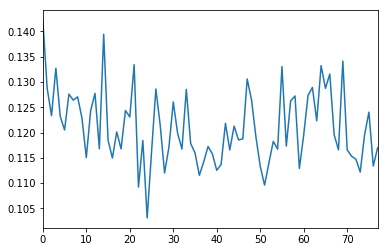

In [10]:
df_loss = pd.DataFrame({"loss":losses})
df_loss["loss"].plot()

In [11]:
import pickle
pickle.dump(ffm,open("model.pkl","wb"))

### Test

In [20]:
test = AvazuDataset(dataset_test_path, "test")
test_loader = DataLoader(test, batch_size=batch_size, num_workers=8)

In [21]:
def test(model, data_loader, device):
    model.eval()
    predicts = list()
    with torch.no_grad():
        for features,_ in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):  
            features = features.to(device)
            y = model(features)
            predicts.extend(y.tolist())
    return predicts

In [22]:
predicted = test(ffm, test_loader, device)

100%|██████████| 4471/4471 [00:23<00:00, 194.34it/s]


### Submit

In [23]:
submit = pd.read_csv("sampleSubmission.gz")

In [24]:
submit["click"]=predicted

In [25]:
submit.head()

,id,click
0,10000174058809263569,0.049765
1,10000182526920855428,0.285481
2,10000554139829213984,0.254113
3,10001094637809798845,0.019071
4,10001377041558670745,0.264455


In [26]:
submit.to_csv("submit.csv", index=False)

In [27]:
!kaggle competitions submit -c avazu-ctr-prediction -f submit.csv -m "40mil rows with embedding 1mil, 2 epoch"

100%|████████████████████████████████████████| 176M/176M [00:02<00:00, 76.6MB/s]
Successfully submitted to Click-Through Rate Prediction

Result: 0.38938